<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Reviewers comment v1</h1>

Hello Andy!

I'm happy to review your project today 🙌

My name is **Justino Imbert** ([this](https://hub.tripleten.com/u/125e88ae) is my Hub profile) and today I'll be reviewing your project!


You can find my comments under the heading **«Review»**. I will categorize my comments in green, blue or red boxes like this:

<div class="alert alert-success">
    <b>Success:</b> if everything is done successfully
</div>
<div class="alert alert-warning">
    <b>Remarks:</b> if I can give some recommendations or ways to improve the project
</div>
<div class="alert alert-danger">
    <b>Needs fixing:</b> if the block requires some corrections. Work cant be accepted with the red comments
</div>

Please dont remove my comments :) If you have any questions dont hesitate to respond to my comments in a different section. 
<div class="alert alert-info"> <b>Student comments:</b> For example like this</div>   


<div class="alert alert-block alert-info">
<b>Reviewer's comment v1:</b> </a>

Amazing job with this submission! I'm approving this project!

Congrats and I wish you the best of luck in the following sprints!

Looking forward to reviewing your future work!
    
</div>


Integrated Project
-

Project Descripion
-
The data is stored in three files:

-  gold_recovery_train.csv — training dataset download
-  gold_recovery_test.csv — test dataset download
-  gold_recovery_full.csv — source dataset download

Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.

Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.

The source dataset contains the training and test sets with all the features.

You have the raw data that was only downloaded from the warehouse. Before building the model, check the correctness of the data. For that, use our instructions.

Imports and Data Preparation
-

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

In [2]:
def describe_data(df, target_name=""):
    data_describe = df.describe().T
    df_numeric = df._get_numeric_data()
    if target_name in df.columns:
        corr_with_target=df_numeric.drop(target_name, axis=1).apply(lambda x: x.corr(df_numeric[target_name]))
        data_describe['corr_with_target']=corr_with_target
    dtype_df = df_numeric.dtypes
    data_describe['dtypes'] = dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %'] = data_null
    Cardinality = df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality'] = Cardinality
    df_skew = df_numeric.skew(axis=0, skipna=True)
    data_describe['Skew'] = df_skew
    return data_describe
    
def missing_values(df):
    df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
    df_nulls.columns = ["type","count","missing_ratio"]
    df_nulls=df_nulls[df_nulls["count"]>0]
    df_nulls.sort_values(by="missing_ratio", ascending=False)
    return df_nulls

In [3]:
#import data
gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_full = pd.read_csv('/datasets/gold_recovery_full.csv')

Data Description
-
Technological process
-  Rougher feed — raw material
-  Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
-  Xanthate — promoter or flotation activator;
-  Sulphate — sodium sulphide for this particular process;
-  Depressant — sodium silicate.
-  Rougher process — flotation
-  Rougher tails — product residues
-  Float banks — flotation unit
-  Cleaner process — purification
-  Rougher Au — rougher gold concentrate
-  Final Au — final gold concentrate

Parameters of stages
-  air amount — volume of air
-  fluid levels
-  feed size — feed particle size
-  feed rate

Feature naming
Here's how you name the features:
-  [stage].[parameter_type].[parameter_name]
-  Example: rougher.input.feed_ag

Possible values for [stage]:
-  rougher — flotation
-  primary_cleaner — primary purification
-  secondary_cleaner — secondary purification
-  final — final characteristics
  
Possible values for [parameter_type]:
-  input — raw material parameters
-  output — product parameters
-  state — parameters characterizing the current state of the stage
-  calculation — calculation characteristics

Data Check and Preparation
-

In [4]:
gold_train.info()
describe_data(gold_train)
missing_values(gold_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,type,count,missing_ratio
final.output.concentrate_ag,float64,72,0.004270
final.output.concentrate_pb,float64,72,0.004270
final.output.concentrate_sol,float64,370,0.021945
final.output.concentrate_au,float64,71,0.004211
final.output.recovery,float64,1521,0.090214
...,...,...,...
secondary_cleaner.state.floatbank5_a_level,float64,85,0.005042
secondary_cleaner.state.floatbank5_b_air,float64,85,0.005042
secondary_cleaner.state.floatbank5_b_level,float64,84,0.004982
secondary_cleaner.state.floatbank6_a_air,float64,103,0.006109


In [5]:
gold_test.info()
describe_data(gold_test)
missing_values(gold_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,type,count,missing_ratio
primary_cleaner.input.sulfate,float64,302,0.051571
primary_cleaner.input.depressant,float64,284,0.048497
primary_cleaner.input.xanthate,float64,166,0.028347
primary_cleaner.state.floatbank8_a_air,float64,16,0.002732
primary_cleaner.state.floatbank8_a_level,float64,16,0.002732
primary_cleaner.state.floatbank8_b_air,float64,16,0.002732
primary_cleaner.state.floatbank8_b_level,float64,16,0.002732
primary_cleaner.state.floatbank8_c_air,float64,16,0.002732
primary_cleaner.state.floatbank8_c_level,float64,16,0.002732
primary_cleaner.state.floatbank8_d_air,float64,16,0.002732


gold_full.info()
describe_data(gold_full)
missing_values(gold_full)

The test set data has 52 items while the train and full set data have 86 items.

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

You did a great job with the preview of the data!

</div>


Check that recovery is calculated correctly
-

Recovery Formula:

R = ((C * (F - T)) / (F * (C - T))) * 100
 
C = rougher.output.concentrate_au

F = rougher.input.feed_au

T = rougher.output.tail_au


In [6]:
def test_recovery(gold):
    # C is the share of gold AFTER flotation
    C = gold['rougher.output.concentrate_au']
    # F is the share of gold BEFORE the flotation
    F = gold['rougher.input.feed_au']
    # T is the share of gold in the tails BEFORE flotation
    T = gold['rougher.output.tail_au']
       
    try:
        test_rougher_output = ((C * (F - T)) / (F * (C - T))) * 100
        return test_rougher_output
    except ZeroDivisionError:
        return 0

true_rougher_output = gold_train['rougher.output.recovery']
test_rougher_output = test_recovery(gold_train)
test_rougher_output.describe()

count    1.457700e+04
mean              NaN
std               NaN
min              -inf
25%      7.965104e+01
50%      8.521533e+01
75%      9.019726e+01
max               inf
dtype: float64

We can see that theres NaN and inf values, most likely due to some values of gold before the flotation being 0 or close to 0.  We need to impliment min and max values before we calculate any further.

In [7]:
test_rougher_output = np.clip(test_rougher_output, 0, 100)
test_rougher_output.describe()

count    14577.000000
mean        81.612537
std         17.386068
min         -0.000000
25%         79.651035
50%         85.215327
75%         90.197257
max        100.000000
dtype: float64

In [8]:
true_rougher_output.describe()

count    14287.000000
mean        82.394201
std         15.096808
min          0.000000
25%         79.818372
50%         85.235997
75%         90.131691
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [9]:
#According to dot, we also need to clean up the true_rougher_output data of missing values in order for MAE to be calculated correctly.
mask = true_rougher_output.notna() & test_rougher_output.notna()
# Apply the mask to both arrays
true_clean = true_rougher_output[mask]
test_clean = test_rougher_output[mask]
print(f"After alignment - True: {len(true_clean)}, Test: {len(test_clean)}")

mae = mean_absolute_error(true_clean, test_clean)
print(f"MAE between calculated and existing recovery: {mae:.4f}")

After alignment - True: 14287, Test: 14287
MAE between calculated and existing recovery: 0.0000


The MAE is 0, or at least really close to 0 which means the values we calculated from test data is very close to the true data.

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Awesome job checking that recovery is calculated correctly!

</div>


Analyze the features not available in the test set
-

In [10]:
gold_full[gold_full.columns[~gold_full.columns.isin(gold_test.columns)]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                                22635 non-null  float64


These are following columns of data that is missing from the test dataset.  They all have float data types.

<div class="alert alert-block alert-warning">
<b>Reviewer's comment v1:</b> </a>

You only need to analyze the features that are missing from the test set, not all of the columns!

</div>


Perform data preprocessing
-

In [11]:
#We need to fill in the missing data values.  
gold_full.fillna(method='ffill', inplace=True)
gold_train.fillna(method='ffill', inplace=True)
gold_test.fillna(method='ffill', inplace=True)

In [12]:
describe_data(gold_train)
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16860 non-null  float64
 2   final.output.concentrate_pb                         16860 non-null  float64
 3   final.output.concentrate_sol                        16860 non-null  float64
 4   final.output.concentrate_au                         16860 non-null  float64
 5   final.output.recovery                               16860 non-null  float64
 6   final.output.tail_ag                                16860 non-null  float64
 7   final.output.tail_pb                                16860 non-null  float64
 8   final.output.tail_sol                               16860 non-null  float64


No missing values and all data types are correct.

Analyze the Data
-

How the concentrations of metals (Au, Ag, Pb) change depending on the purification stage
-

In [13]:
#Start with a function to visualize the different metals
def visual_metal(metal):
    print('Sum\n', metal.sum(), '\n')
    print('Descriptive stats:\n', metal.describe())
    metal.plot(kind = 'hist', bins = 50, title = 'metal ratio based on stage', xlabel = 'percent', density = True,
               alpha = 0.25, grid = True, figsize = (15,8))

Sum
 rougher.input.feed_au                    120452.542860
rougher.output.concentrate_au            292312.985304
primary_cleaner.output.concentrate_au    489644.513863
final.output.concentrate_au              662962.701609
dtype: float64 

Descriptive stats:
        rougher.input.feed_au  rougher.output.concentrate_au  \
count           16860.000000                   16860.000000   
mean                7.144279                      17.337662   
std                 3.026064                       6.985496   
min                 0.000000                       0.000000   
25%                 6.186757                      17.400564   
50%                 7.429346                      19.631078   
75%                 8.954083                      21.219480   
max                14.093363                      28.522811   

       primary_cleaner.output.concentrate_au  final.output.concentrate_au  
count                           16860.000000                 16860.000000  
mean              

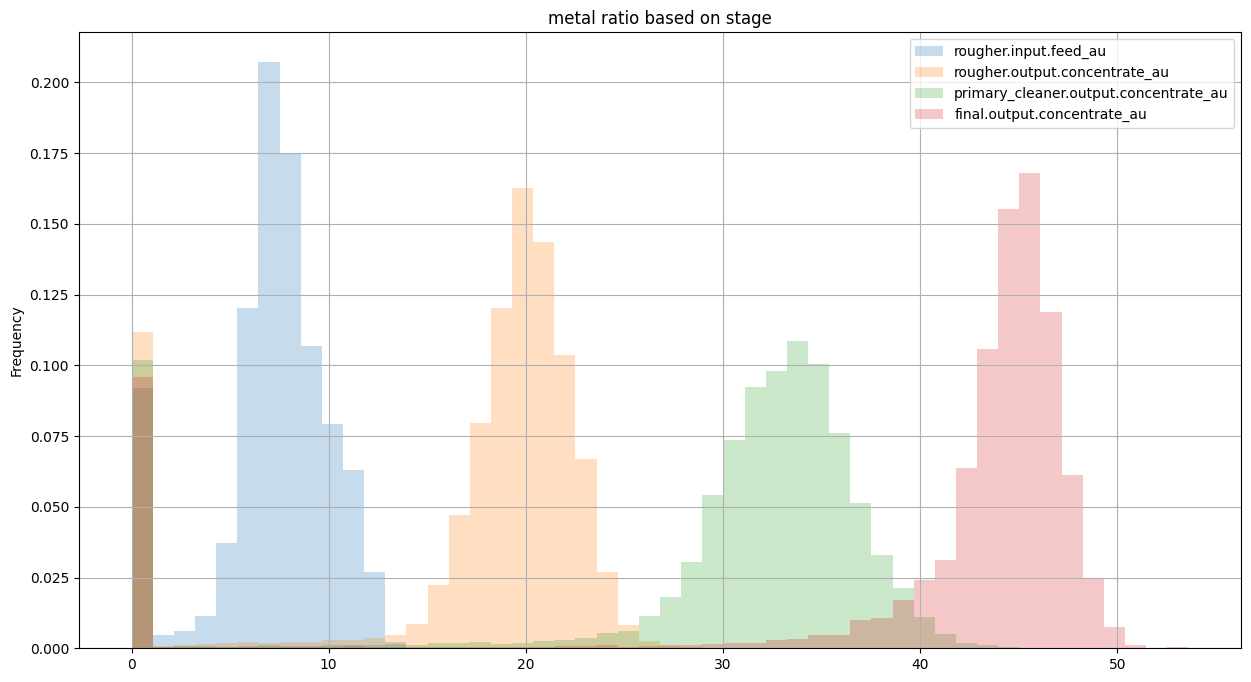

In [14]:
gold_concentrations = gold_train[['rougher.input.feed_au', 'rougher.output.concentrate_au', 
                               'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
visual_metal(gold_concentrations)

Sum
 rougher.input.feed_ag                    131572.493270
rougher.output.concentrate_ag            177736.945611
primary_cleaner.output.concentrate_ag    124605.260889
final.output.concentrate_ag               79226.246976
dtype: float64 

Descriptive stats:
        rougher.input.feed_ag  rougher.output.concentrate_ag  \
count           16860.000000                   16860.000000   
mean                7.803825                      10.541930   
std                 3.167145                       4.486629   
min                 0.000000                       0.000000   
25%                 6.880442                       9.953223   
50%                 7.929318                      11.444529   
75%                 9.816174                      13.267408   
max                14.869652                      24.480271   

       primary_cleaner.output.concentrate_ag  final.output.concentrate_ag  
count                           16860.000000                 16860.000000  
mean              

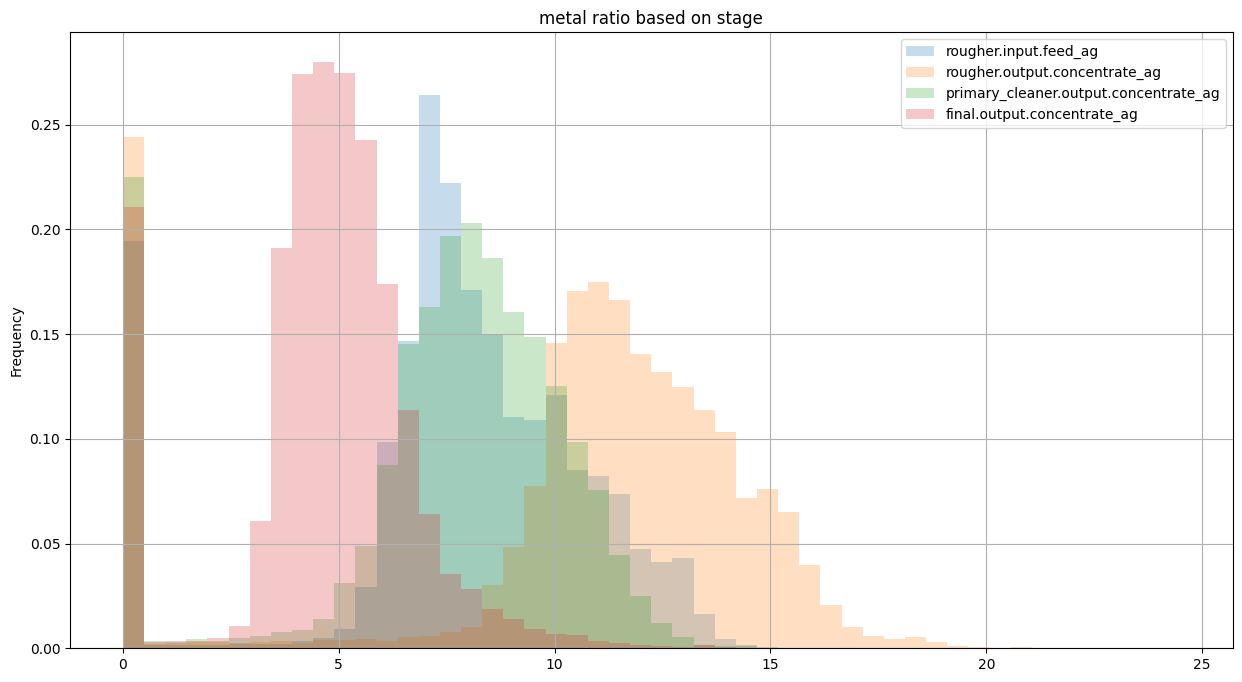

In [15]:
silver_concentrations = gold_train[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 
                               'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
visual_metal(silver_concentrations)

Sum
 rougher.input.feed_pb                     53763.210851
rougher.output.concentrate_pb            115680.665135
primary_cleaner.output.concentrate_pb    143203.334939
final.output.concentrate_pb              153099.552443
dtype: float64 

Descriptive stats:
        rougher.input.feed_pb  rougher.output.concentrate_pb  \
count           16860.000000                   16860.000000   
mean                3.188803                       6.861249   
std                 1.495402                       2.959401   
min                 0.000000                       0.000000   
25%                 2.516519                       6.331015   
50%                 3.278689                       7.578584   
75%                 4.169530                       8.501206   
max                 7.142594                      18.394042   

       primary_cleaner.output.concentrate_pb  final.output.concentrate_pb  
count                           16860.000000                 16860.000000  
mean              

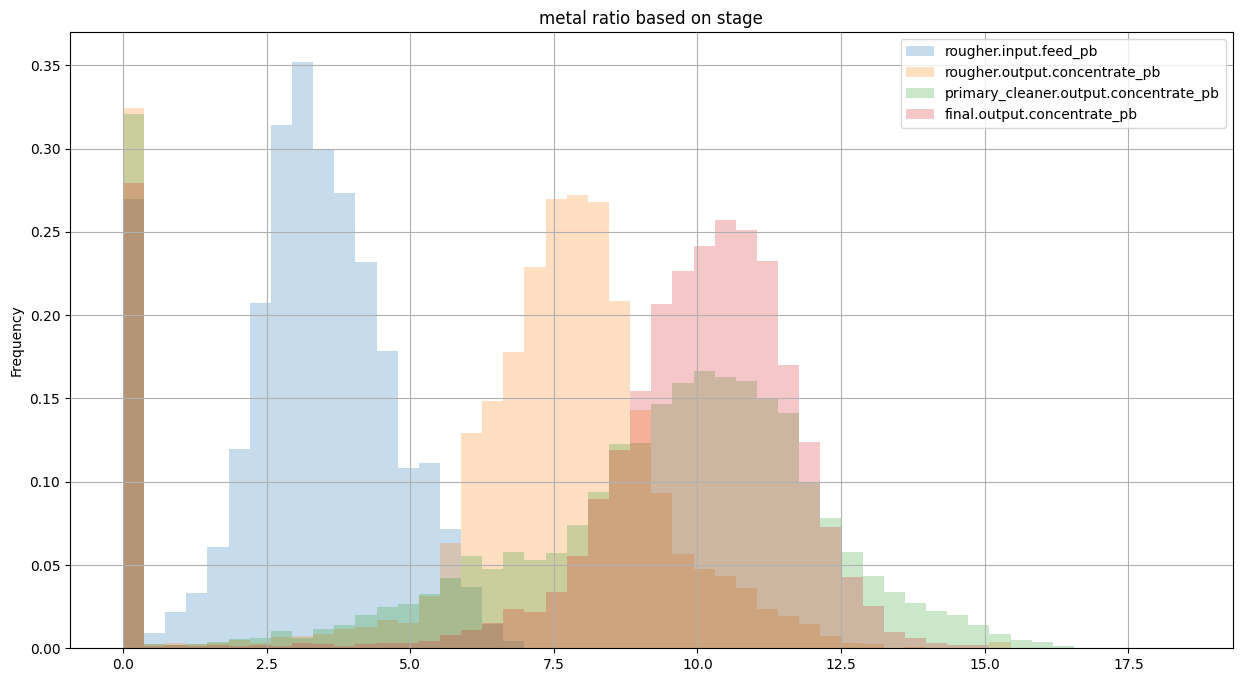

In [16]:
lead_concentrations = gold_train[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 
                               'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
visual_metal(lead_concentrations)

The concentration of gold increases steadily as it progressed through the purificaion stages.  The concentration of silver decreases as we move through the purification stages.  The concentration of lead also increases as we progress through the purification stages.
-  Gold (Au): Increases steadily from ~7% → 17% → 29% → 39%
-  Silver (Ag): Decreases from ~8% → 11% → 7% → 5% 
-  Lead (Pb): Increases from ~3% → 7% → 8% → 9%
  
Potential explanation is that lead has similar flotation properties to gold, therefore it can also be confused as gold in the purification process.

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Excellent visualization. The code correctly compares metal concentrations across purification stages!
    
</div>

Compare the feed particle size distributions in the training set and in the test set
-

Training Set:
 count    16860.000000
mean         7.297285
std          0.619166
min          1.080000
25%          6.940000
50%          7.285000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

Testing Set:
 count    5856.000000
mean        7.264651
std         0.611526
min         5.650000
25%         6.885625
50%         7.259333
75%         7.650000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64


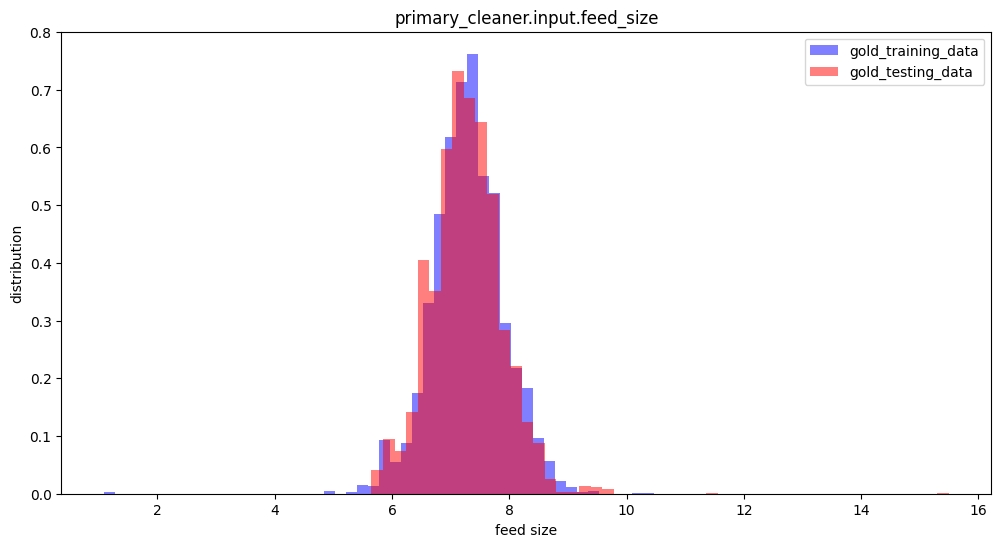

In [17]:
#Data comparison of primary cleaner input
print("Training Set:\n", gold_train['primary_cleaner.input.feed_size'].describe())
print("\nTesting Set:\n", gold_test['primary_cleaner.input.feed_size'].describe())

plt.figure(figsize=(12, 6))
plt.hist(gold_train['primary_cleaner.input.feed_size'], density=True, alpha=0.5, bins=50, color='blue')
plt.hist(gold_test["primary_cleaner.input.feed_size"], density=True, alpha=0.5, bins=50, color='red')
plt.title('primary_cleaner.input.feed_size')
plt.xlabel('feed size')
plt.ylabel('distribution')
plt.legend(['gold_training_data', 'gold_testing_data'])
plt.show()

Training Set:
 count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Testing Set:
 count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64


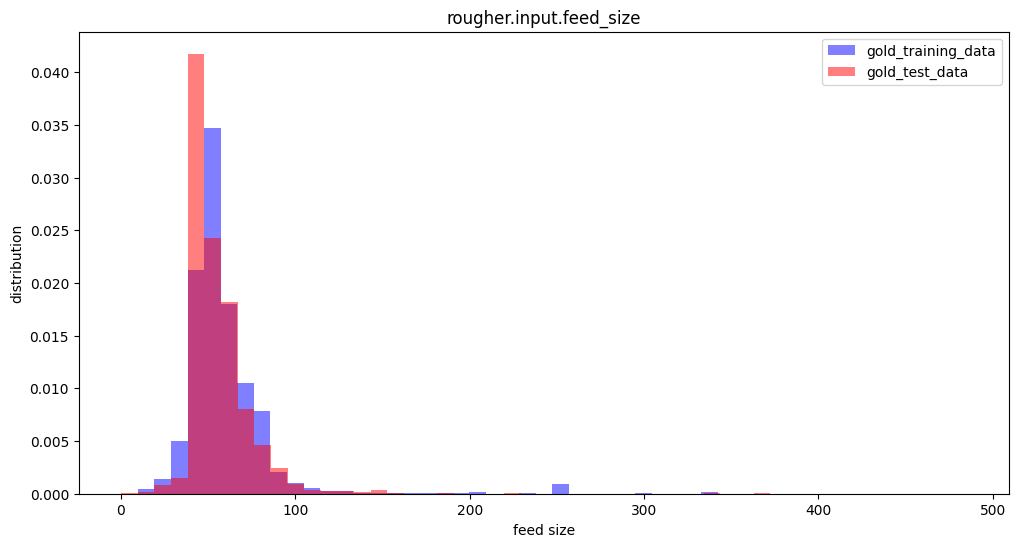

In [18]:
#Data comparison of rougher input
print("Training Set:\n", gold_train['rougher.input.feed_size'].describe())
print("\nTesting Set:\n", gold_test['rougher.input.feed_size'].describe())

plt.figure(figsize=(12, 6))
plt.hist(gold_train['rougher.input.feed_size'], density = True, alpha = 0.5, bins = 50, color = 'blue')
plt.hist(gold_test["rougher.input.feed_size"], density = True, alpha = 0.5, bins = 50, color = 'red')
plt.title('rougher.input.feed_size')
plt.xlabel('feed size')
plt.ylabel('distribution')
plt.legend(['gold_training_data', 'gold_test_data'])
plt.show()

Primary Cleaner Feed Size:
-  Means: Training (7.30) vs Test (7.26) - nearly identical
-  Standard deviations: Training (0.62) vs Test (0.61) - very close
-  Distribution shape: Both show normal, bell-shaped distributions centered around 7.3

Rougher Feed Size:
-  Means: Training (60.19) vs Test (55.90) - reasonably close
-  Standard deviations: Training (30.52) vs Test (22.71) - test set slightly less variable
-  Distribution shape: Both show right-skewed distributions with similar patterns

The primary cleaner shows almost perfect similarity, while the rougher process shows good similarity with slightly less variability in the test set. This suggests that the model should generalize well to new data.

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

You’re doing an incredible job!
    
</div>

Consider the total concentrations of all substances at different stages. Describe the findings and eliminate anomalies.
-

In [19]:
# Calculate total concentrations for each stage
# Raw feed stage (rougher input)
gold_train['total_feed'] = (gold_train['rougher.input.feed_au'] + 
                           gold_train['rougher.input.feed_ag'] + 
                           gold_train['rougher.input.feed_pb'])

# Rougher concentrate stage (rougher output)
gold_train['total_rougher'] = (gold_train['rougher.output.concentrate_au'] + 
                              gold_train['rougher.output.concentrate_ag'] + 
                              gold_train['rougher.output.concentrate_pb'])

# Final concentrate stage (final output)
gold_train['total_final'] = (gold_train['final.output.concentrate_au'] + 
                            gold_train['final.output.concentrate_ag'] + 
                            gold_train['final.output.concentrate_pb'])

In [20]:
# Calculate total concentrations for test set
gold_test['total_feed'] = (gold_test['rougher.input.feed_au'] + 
                          gold_test['rougher.input.feed_ag'] + 
                          gold_test['rougher.input.feed_pb'])

# Note: Test set doesn't have final output data, so we can only calculate feed totals

In [21]:
# Check descriptive statistics for each total concentration
print("=== TOTAL FEED CONCENTRATIONS ===")
print("Training Set:")
print(gold_train['total_feed'].describe())
print("\nTest Set:")
print(gold_test['total_feed'].describe())

print("\n=== TOTAL ROUGHER CONCENTRATIONS ===")
print("Training Set:")
print(gold_train['total_rougher'].describe())

print("\n=== TOTAL FINAL CONCENTRATIONS ===")
print("Training Set:")
print(gold_train['total_final'].describe())

=== TOTAL FEED CONCENTRATIONS ===
Training Set:
count    16860.000000
mean        18.136907
std          7.407993
min          0.000000
25%         16.093185
50%         18.713815
75%         22.327806
max         35.071987
Name: total_feed, dtype: float64

Test Set:
count    5856.000000
mean       20.992454
std         6.851637
min         0.000000
25%        18.644178
50%        22.599185
75%        24.969307
max        33.498784
Name: total_feed, dtype: float64

=== TOTAL ROUGHER CONCENTRATIONS ===
Training Set:
count    16860.000000
mean        34.740842
std         13.697400
min          0.000000
25%         36.609887
50%         39.457951
75%         41.635606
max         55.568687
Name: total_rougher, dtype: float64

=== TOTAL FINAL CONCENTRATIONS ===
Training Set:
count    16860.000000
mean        53.101335
std         18.691789
min          0.000000
25%         58.523841
50%         59.984051
75%         60.934848
max         65.575259
Name: total_final, dtype: float64


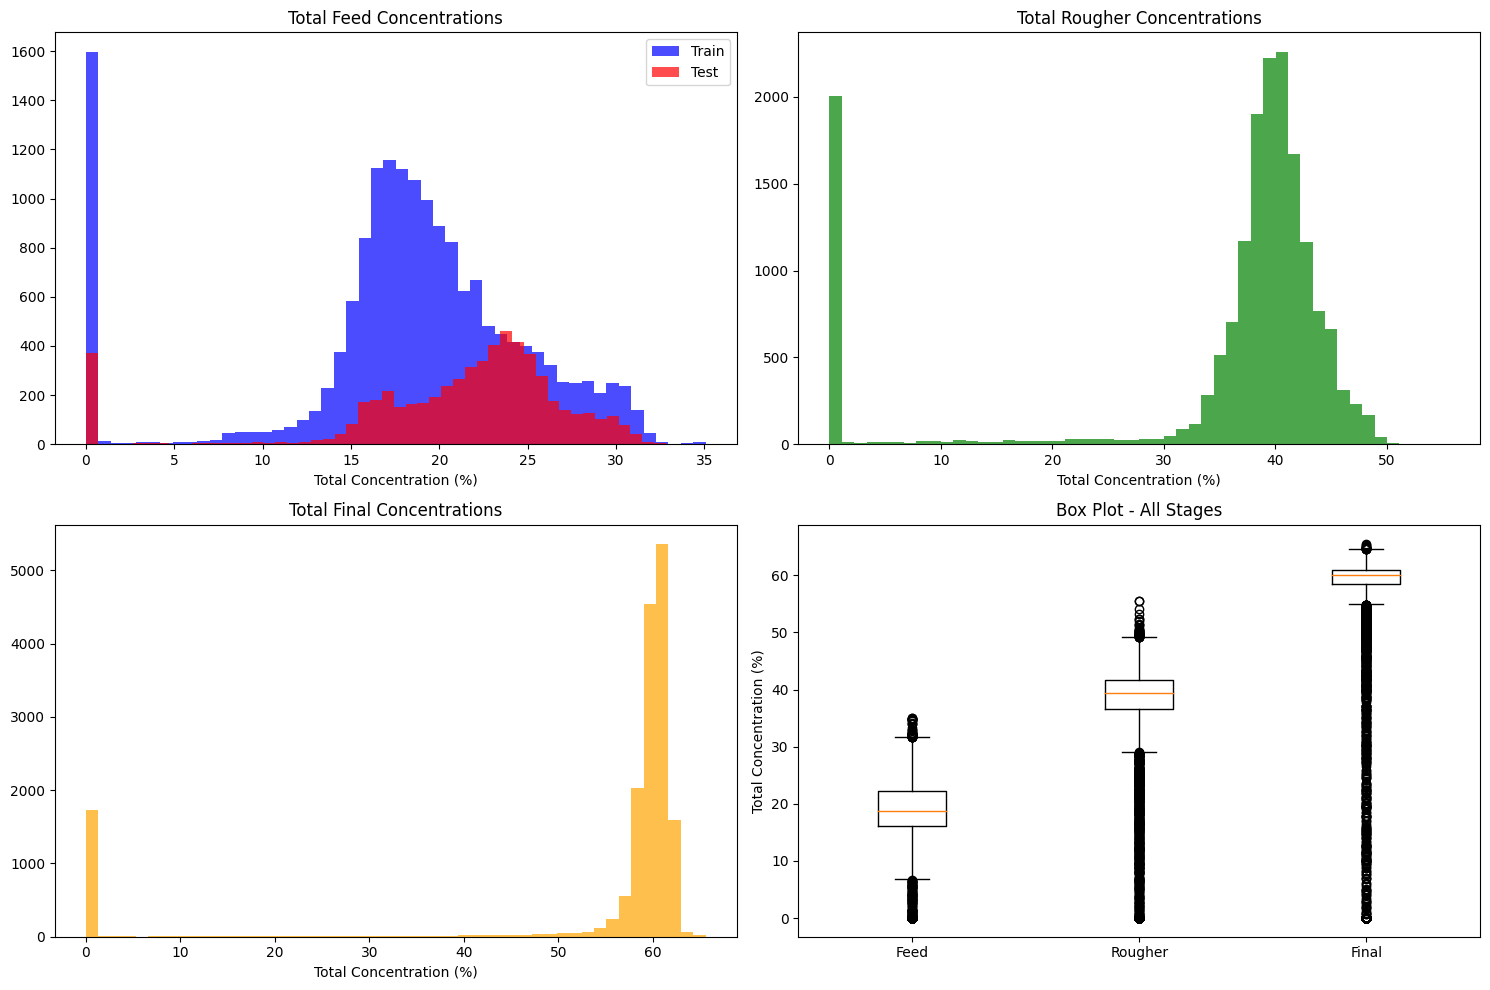

In [22]:
# Create visualizations to identify outliers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total feed concentrations
axes[0,0].hist(gold_train['total_feed'], bins=50, alpha=0.7, color='blue', label='Train')
axes[0,0].hist(gold_test['total_feed'], bins=50, alpha=0.7, color='red', label='Test')
axes[0,0].set_title('Total Feed Concentrations')
axes[0,0].set_xlabel('Total Concentration (%)')
axes[0,0].legend()

# Total rougher concentrations
axes[0,1].hist(gold_train['total_rougher'], bins=50, alpha=0.7, color='green')
axes[0,1].set_title('Total Rougher Concentrations')
axes[0,1].set_xlabel('Total Concentration (%)')

# Total final concentrations
axes[1,0].hist(gold_train['total_final'], bins=50, alpha=0.7, color='orange')
axes[1,0].set_title('Total Final Concentrations')
axes[1,0].set_xlabel('Total Concentration (%)')

# Box plot to identify outliers
axes[1,1].boxplot([gold_train['total_feed'], gold_train['total_rougher'], gold_train['total_final']], 
                  labels=['Feed', 'Rougher', 'Final'])
axes[1,1].set_title('Box Plot - All Stages')
axes[1,1].set_ylabel('Total Concentration (%)')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Awesome plots! Looking good!

</div>


In [23]:
# Find samples with extremely high total concentrations
print("=== SAMPLES WITH HIGHEST TOTAL FINAL CONCENTRATIONS ===")
high_final = gold_train.nlargest(10, 'total_final')[['date', 'total_final', 
                                                     'final.output.concentrate_au',
                                                     'final.output.concentrate_ag', 
                                                     'final.output.concentrate_pb']]
print(high_final)

print("\n=== SAMPLES WITH ZERO TOTAL CONCENTRATIONS ===")
zero_samples = gold_train[gold_train['total_final'] == 0.0][['date', 'total_final',
                                                             'final.output.concentrate_au',
                                                             'final.output.concentrate_ag', 
                                                             'final.output.concentrate_pb']]
print(f"Number of zero concentration samples: {len(zero_samples)}")
print(zero_samples.head())

=== SAMPLES WITH HIGHEST TOTAL FINAL CONCENTRATIONS ===
                      date  total_final  final.output.concentrate_au  \
1852   2016-04-01 04:00:00    65.575259                    44.811483   
1854   2016-04-01 06:00:00    65.291103                    44.622220   
1853   2016-04-01 05:00:00    65.162859                    44.525189   
15666  2018-06-29 17:59:59    64.968881                    48.758706   
15668  2018-06-29 19:59:59    64.938913                    48.304780   
15672  2018-06-29 23:59:59    64.856303                    48.524266   
15675  2018-06-30 02:59:59    64.855463                    48.722145   
15687  2018-06-30 14:59:59    64.841606                    47.467657   
15676  2018-06-30 03:59:59    64.832573                    48.496702   
15674  2018-06-30 01:59:59    64.693485                    48.486786   

       final.output.concentrate_ag  final.output.concentrate_pb  
1852                     14.066034                     6.697742  
1854               

In [24]:
# Define realistic bounds for total concentrations
print("=== ANOMALY ANALYSIS ===")

# Count anomalies
zero_anomalies = (gold_train['total_final'] == 0.0).sum()
high_anomalies = (gold_train['total_final'] > 65.0).sum()

print(f"Zero concentration samples: {zero_anomalies}")
print(f"High concentration samples (>65%): {high_anomalies}")
print(f"Total anomalies: {zero_anomalies + high_anomalies}")
print(f"Percentage of data: {(zero_anomalies + high_anomalies)/len(gold_train)*100:.2f}%")

=== ANOMALY ANALYSIS ===
Zero concentration samples: 1320
High concentration samples (>65%): 3
Total anomalies: 1323
Percentage of data: 7.85%


The following are findings based on the analysis performed:
1. Zero Concentration Anomalies:
- 1,320 samples (7.8% of training data) have total_final = 0.0%
- This means all three metals (Au, Ag, Pb) are exactly 0.0% in the final concentrate
- This is physically impossible - you cannot have a "final concentrate" with zero metals

2. Extremely High Concentrations:
- Maximum final concentration: 65.58%
- Top 10 samples all above 64.8%
- This means 35%+ of the final product is non-valuable material

3. Distribution Patterns:
- Feed: ~18% → Rougher: ~35% → Final: ~53% (normal progression)
- But wide variation in final stage (std = 18.7%)

Looks like we have about 8-10% of the data that is quite an anomaly. This is a large chunk of the data that most likely can't just be excluded because of its major impact on the model.

Build the model
-

In [25]:
#Write a function to calculate final sMAPE value
def calc_smape(target, prediction):
    """Calculate symmetric Mean Absolute Percentage Error"""
    # Handle edge cases where both target and prediction are zero
    mask = (target != 0) | (prediction != 0)
    
    if not mask.any():
        return 0.0
    
    target_filtered = target[mask]
    prediction_filtered = prediction[mask]
    
    numerator = np.abs(prediction_filtered - target_filtered)
    denominator = 0.5 * (np.abs(target_filtered) + np.abs(prediction_filtered))
    
    # Avoid division by zero
    denominator = np.where(denominator == 0, 1e-8, denominator)
    
    smape = 100 * np.mean(numerator / denominator)
    return smape

def final_smape(target, prediction):
    # target and prediction are both numpy arrays of shape (n_samples, 2)
    r_smape = calc_smape(target[:, 0], prediction[:, 0])   # rougher recovery
    f_smape = calc_smape(target[:, 1], prediction[:, 1])   # final recovery
    
    final_smape = (0.25 * r_smape) + (0.75 * f_smape)
    return final_smape

In [26]:
smape_scorer = make_scorer(final_smape, greater_is_better=False)

def cross_validation_scores(model_type, feature, target):

    kfold = KFold(n_splits = 5, random_state = 12345, shuffle = True)

    cross_val_smape = np.abs(cross_val_score(model_type, feature, target, scoring = smape_scorer, cv = kfold))

    print("Cross-Validation sMAPE Scores:")
    print('Mean:', cross_val_smape.mean())
    print('Min:', cross_val_smape.min())
    print('Max:', cross_val_smape.max())

In [27]:
def split_data_training(data, test_size=0.2, random_state=12345):
    """
    Split training data for model development
    """
    # Define features (exclude targets and date)
    feature_cols = [col for col in data.columns if not col.startswith(('rougher.output.recovery', 'final.output.recovery', 'date'))]
    
    # Extract features
    X = data[feature_cols]
    
    # Extract targets - how should we structure this?
    y = data[['rougher.output.recovery', 'final.output.recovery']].values
    
    # Split the data - which method should we use?
    features_train, features_test, target_train, target_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state
    )
    
    return features_train, features_test, target_train, target_test

In [28]:
features_train, features_test, target_train, target_test = split_data_training(gold_train)

In [29]:
#Decision Tree Model
dec_tree = DecisionTreeRegressor(random_state = 12345)
print('Decision Tree model:')
cross_validation_scores(dec_tree, features_train, target_train)

Decision Tree model:
Cross-Validation sMAPE Scores:
Mean: 5.301741577227705
Min: 4.747789980021596
Max: 5.595397583883598


In [30]:
#linear Regression Model
lin_reg = LinearRegression()
print('Linear Regression model:')
cross_validation_scores(lin_reg, features_train, target_train)

Linear Regression model:
Cross-Validation sMAPE Scores:
Mean: 9.958693341608786
Min: 9.388709268200234
Max: 10.547909756477429


In [31]:
#Random Forest Model
random_forest = RandomForestRegressor(random_state = 12345)
print('Random Forest model:')
cross_validation_scores(random_forest, features_train, target_train)

Random Forest model:
Cross-Validation sMAPE Scores:
Mean: 5.019193939116358
Min: 4.487678854214047
Max: 5.371538365735567


It looks like Random Forest model yields our best results according to the sMAPE scores.  We will proceed to hyperparameter tuning.

In [32]:
param_grid = {
    'max_depth': [1, 3, 5, 7, 11, 13, None],
    'min_samples_leaf': [1, 3, 5, 7, 11, 13],
    'max_features': ['auto', 'sqrt', 'log2']
}

model = RandomForestRegressor(random_state = 12345)

# set grid to model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                           scoring = smape_scorer, cv = 5, n_jobs = -1, verbose = 2)

In [33]:
# fit the grid to the data
grid_search.fit(features_train, target_train)
best_param = grid_search.best_params_

print("\n Best score:\n",
          grid_search.best_score_)
    
print("\n Best parameters:\n",
          grid_search.best_params_)

Fitting 5 folds for each of 126 candidates, totalling 630 fits
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=1; total time=   5.2s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=1; total time=   5.2s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=1; total time=   5.2s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=3; total time=   5.3s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=3; total time=   5.5s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=5; total time=   5.6s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=5; total time=   5.6s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=5; total time=   5.8s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=7; total time=   5.8s
[CV] END .max_depth=1, max_features=auto, min_samples_leaf=7; total time=   5.6s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=11; total time=   5.7s
[CV] END max_depth=1, max_features=auto, min_s

In [34]:
#Train model with best hyperparameters
model = RandomForestRegressor(random_state = 12345, max_depth = None, min_samples_leaf = 1, max_features = 'auto')
model.fit(features_train, target_train)
prediction = model.predict(features_test)

cross_validation_scores(model, features_train, target_train)

[CV] END max_depth=None, max_features=log2, min_samples_leaf=3; total time=   5.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=3; total time=   5.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=3; total time=   5.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=5; total time=   4.8s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=5; total time=   4.7s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=5; total time=   4.8s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=7; total time=   4.6s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=7; total time=   4.6s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=11; total time=   4.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=11; total time=   4.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=13; total time=   4.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=13; total time=   4.2s


In [35]:
# Create dummy model - remove random_state for 'mean' strategy
dummy_model = DummyRegressor(strategy='mean')

# Test it with cross-validation
print('Dummy Model (Mean Strategy):')
cross_validation_scores(dummy_model, features_train, target_train)

Dummy Model (Mean Strategy):
Cross-Validation sMAPE Scores:
Mean: 14.90639677696692
Min: 14.100162591680938
Max: 15.560454698792686


The best model with the best hyperparameters is Random Forest.  Through cross validation, it yields the lowest sMAPE scores.  Comparing it to the Dummy Model, the Random Forest model performs 3x better.  Random Forest model can predict gold recovery with about 5% error, while simply predicting the average recovery would give you 15% error. For a mining operation, this level of accuracy improvement could translate to:
-  Better process optimization
-  Reduced waste
-  More efficient resource allocation
-  Improved profitability

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Good job training different models and testing the best one using the test set!

You did a nice job all throughout this submission! You should be proud! Keep up the great work!

</div>
